In [1]:
import pandas as pd
pd.options.display.max_rows = 10099
pd.options.display.max_columns = 999


In [2]:
tweets = pd.read_csv('tweets.csv').rename(columns={'Tweet': 'text'})

In [3]:
new_tweets = pd.read_csv('tweets_20220531.csv').rename(columns={'Tweet': 'text'})

In [4]:
new_tweets['labels'] = ''

In [5]:
new_tweets = new_tweets[['text','labels']]

In [6]:
tweets.head()

,ID,Foundation_Name,text,theme_1,theme_2,Tweet_Date,Tweeted_by_Foundation,Query_Term,Handle_Type,Region
0,1500694853277335552,Anfrel,#MyanmarSituationUpdate: Here are the incident...,incident,NaN,2022-03-07,True,@Anfrel,Org,Asia
1,1501202326798974976,WITNESS_Asia,"RT @Altsean: ""The Rohingya are the most persec...",rohingya,NaN,2022-03-08,True,@WITNESS_Asia,Org,Asia
2,1501026064281309184,Altsean,RT @Altsean: More #InspiringWomen from #Burma ...,women,NaN,2022-03-08,True,@Altsean,Org,Myanmar
3,1501022642299670537,Anfrel,"As we celebrate #WomensMonth and today, March ...",women,NaN,2022-03-08,True,@Anfrel,Org,Asia
4,1501261106957934600,ChinHumanRights,@ChinHumanRights today issued a new report det...,report,chin,2022-03-08,True,@ChinHumanRights,Org,Myanmar


In [7]:
new_tweets.head()

,text,labels
0,RT @NDBurma: A new flash report by ND-Burma me...,
1,RT @ZinMarAungNUG: @NUGMyanmar is deeply conce...,
2,RT @cvdom2021: @MadihaAfzal Myanmar’s democrat...,
3,"RT @cvdom2021: China, please work with @NUGMya...",
4,RT @benedictrogers: A huge privilege and joy t...,


# Select for only text and theme

In [69]:
df = tweets[['text', 'theme_1', 'theme_2']]

In [70]:
df.head()

,text,theme_1,theme_2
0,#MyanmarSituationUpdate: Here are the incident...,incident,NaN
1,"RT @Altsean: ""The Rohingya are the most persec...",rohingya,NaN
2,RT @Altsean: More #InspiringWomen from #Burma ...,women,NaN
3,"As we celebrate #WomensMonth and today, March ...",women,NaN
4,@ChinHumanRights today issued a new report det...,report,chin


In [73]:
df.shape

(131, 4)

In [75]:
df = pd.concat([df, new_tweets])

In [79]:
df.shape

(336, 4)

## Create a labels column that is vector

In [80]:
# combine labels together
df['labels'] = df['theme_1'].fillna('').str.cat(df['theme_2'].fillna(''), sep = ", ")
# remove trailing comma
df['labels'] = df['labels'].str.rstrip(', ')

In [82]:
df.tail()

,text,theme_1,theme_2,labels
200,"RT @MIJamjoom: Without education, ""we (#Rohing...",NaN,NaN,
201,RT @IFEX: 🇲🇲 #Myanmar: @JusticeMyanmar has war...,NaN,NaN,
202,RT @Altsean: The fall in #vaccine coverage by ...,NaN,NaN,
203,RT @Reaproy: Tharindu Abeyrathna of @Anfrel br...,NaN,NaN,
204,RT @Reaproy: Tomorrow (5/30) evening in #Bangk...,NaN,NaN,


## See how many labels exist

In [83]:
df["labels"].apply(lambda x : len(x)).value_counts().to_frame().T

,0,8,5,6,9,12,17,18,16,15,14,10,4,13,11,22,20,19,7
labels,217,28,19,18,8,8,7,5,5,4,4,3,3,2,1,1,1,1,1


In [84]:
# Look at top 10 most frequent labels
df_counts = df["labels"].explode().value_counts()
print(f"Number of labels: {len(df_counts)}")
# Display the top-8 label categories
df_counts.to_frame().head(8).T

Number of labels: 47


,,rohingya,event,elections,report,women,policy,prison
labels,217,18,9,7,7,6,6,5


In [85]:
all_labels = ['rohingya', 'event', 'elections', 'report', 'women' , 'policy' , 'prison']

In [86]:
df["split"] = "unlabeled"
df.head()

,text,theme_1,theme_2,labels,split
0,#MyanmarSituationUpdate: Here are the incident...,incident,NaN,incident,unlabeled
1,"RT @Altsean: ""The Rohingya are the most persec...",rohingya,NaN,rohingya,unlabeled
2,RT @Altsean: More #InspiringWomen from #Burma ...,women,NaN,women,unlabeled
3,"As we celebrate #WomensMonth and today, March ...",women,NaN,women,unlabeled
4,@ChinHumanRights today issued a new report det...,report,chin,"report, chin",unlabeled


In [87]:
mask = df["labels"].apply(lambda x: len(x)) > 0
df.loc[mask, "split"] = "labeled"

In [88]:
df['split'].value_counts().to_frame()

,split
unlabeled,217
labeled,119


## Drop duplicates

In [89]:
len_before = len(df)
df = df.drop_duplicates(subset="text")
print(f"Removed {(len_before-len(df))/len_before:.2%} duplicates.")

Removed 0.00% duplicates.


## Visualize number of words

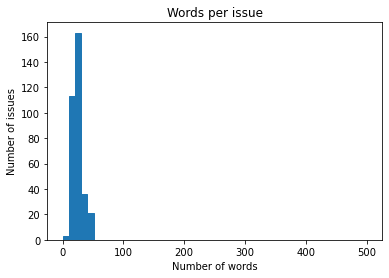

In [90]:
import numpy as np
import matplotlib.pyplot as plt

(df["text"].str.split().apply(len)
 .hist(bins=np.linspace(0, 500, 50), grid=False, edgecolor="C0"))
plt.title("Words per issue")
plt.xlabel("Number of words")
plt.ylabel("Number of issues")
plt.show()

# Create Training Set

In [91]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
mlb.fit([all_labels])

# Check how it transforms labels
mlb.transform([["rohingya", "women"], ["event"]])


array([[0, 0, 0, 0, 0, 1, 1],
       [0, 1, 0, 0, 0, 0, 0]])

# Create iterative train_test_split

In [92]:
from skmultilearn.model_selection import iterative_train_test_split

def balanced_split(df, test_size=0.5):
    ind = np.expand_dims(np.arange(len(df)), axis=1)
    labels = mlb.transform(df["labels"])
    ind_train, _, ind_test, _ = iterative_train_test_split(ind, labels,
                                                           test_size)
    return df.iloc[ind_train[:, 0]], df.iloc[ind_test[:,0]]


## Split into supervised and unsupervised datasets


In [95]:
from sklearn.model_selection import train_test_split

df_clean = df[["text", "labels", "split"]].reset_index(drop=True).copy()
df_unsup = df_clean.loc[df_clean["split"] == "unlabeled", ["text", "labels"]]
df_sup = df_clean.loc[df_clean["split"] == "labeled", ["text", "labels"]]

np.random.seed(0)
df_train, df_tmp = balanced_split(df_sup, test_size=0.5)
df_valid, df_test = balanced_split(df_tmp, test_size=0.5)

/opt/conda/envs/bertopic_gpu/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:876: UserWarning: unknown class(es) [' ', ',', 'a', 'b', 'c', 'd', 'e', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y'] will be ignored
  "unknown class(es) {0} will be ignored".format(sorted(unknown, key=str))
/opt/conda/envs/bertopic_gpu/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:876: UserWarning: unknown class(es) [' ', ',', 'a', 'b', 'c', 'd', 'e', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'y'] will be ignored
  "unknown class(es) {0} will be ignored".format(sorted(unknown, key=str))


In [96]:
df_train.shape

(60, 2)

## Create datasetdict with all the splits to tokenize the dataset and integrate with trainer

In [97]:
from datasets import Dataset, DatasetDict

ds = DatasetDict({
    "train": Dataset.from_pandas(df_train.reset_index(drop=True)),
    "valid": Dataset.from_pandas(df_valid.reset_index(drop=True)),
    "test": Dataset.from_pandas(df_test.reset_index(drop=True)),
    "unsup": Dataset.from_pandas(df_unsup.reset_index(drop=True))})


In [98]:
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 60
    })
    valid: Dataset({
        features: ['text', 'labels'],
        num_rows: 30
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 29
    })
    unsup: Dataset({
        features: ['text', 'labels'],
        num_rows: 217
    })
})

## Create Training Slices

In [100]:
np.random.seed(0)
all_indices = np.expand_dims(list(range(len(ds["train"]))), axis=1)
indices_pool = all_indices
labels = mlb.transform(ds["train"]["labels"])
train_samples = [8, 16, 32]
train_slices, last_k = [], 0

for i, k in enumerate(train_samples):
    # Split off samples necessary to fill the gap to the next split size
    indices_pool, labels, new_slice, _ = iterative_train_test_split(
        indices_pool, labels, (k-last_k)/len(labels))
    last_k = k
    if i==0: train_slices.append(new_slice)
    else: train_slices.append(np.concatenate((train_slices[-1], new_slice)))

# Add full dataset as last slice
train_slices.append(all_indices), train_samples.append(len(ds["train"]))
train_slices = [np.squeeze(train_slice) for train_slice in train_slices]


In [101]:
print("Target split sizes:")
print(train_samples)
print("Actual split sizes:")
print([len(x) for x in train_slices])


Target split sizes:
[8, 16, 32, 60]
Actual split sizes:
[8, 16, 32, 60]


# Naive Bayes

In [102]:
def prepare_labels(batch):
    batch["label_ids"] = mlb.transform(batch["labels"])
    return batch

In [103]:
ds = ds.map(prepare_labels, batched = True)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

/opt/conda/envs/bertopic_gpu/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:876: UserWarning: unknown class(es) [' ', ',', 'a', 'c', 'd', 'e', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'y'] will be ignored
  "unknown class(es) {0} will be ignored".format(sorted(unknown, key=str))


  0%|          | 0/1 [00:00<?, ?ba/s]

/opt/conda/envs/bertopic_gpu/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:876: UserWarning: unknown class(es) [' ', ',', 'a', 'b', 'c', 'd', 'e', 'g', 'h', 'i', 'j', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'y'] will be ignored
  "unknown class(es) {0} will be ignored".format(sorted(unknown, key=str))


  0%|          | 0/1 [00:00<?, ?ba/s]

# Evaluate

In [104]:
from collections import defaultdict

In [105]:
macro_scores, micro_scores = defaultdict(list), defaultdict(list)


In [106]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.feature_extraction.text import CountVectorizer


In [107]:
for train_slice in train_slices:
    # Get training slice and test data
    ds_train_sample = ds["train"].select(train_slice)
    y_train = np.array(ds_train_sample["label_ids"])
    y_test = np.array(ds["test"]["label_ids"])
    # Use a simple count vectorizer to encode our texts as token counts
    count_vect = CountVectorizer()
    X_train_counts = count_vect.fit_transform(ds_train_sample["text"])
    X_test_counts = count_vect.transform(ds["test"]["text"])
    # Create and train our model!
    classifier = BinaryRelevance(classifier=MultinomialNB())
    classifier.fit(X_train_counts, y_train)
    # Generate predictions and evaluate
    y_pred_test = classifier.predict(X_test_counts)
    clf_report = classification_report(
        y_test, y_pred_test, target_names=mlb.classes_, zero_division=0,
        output_dict=True)
    # Store metrics
    macro_scores["Naive Bayes"].append(clf_report["macro avg"]["f1-score"])
    micro_scores["Naive Bayes"].append(clf_report["micro avg"]["f1-score"])

In [108]:
import matplotlib.pyplot as plt

def plot_metrics(micro_scores, macro_scores, sample_sizes, current_model):
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

    for run in micro_scores.keys():
        if run == current_model:
            ax0.plot(sample_sizes, micro_scores[run], label=run, linewidth=2)
            ax1.plot(sample_sizes, macro_scores[run], label=run, linewidth=2)
        else:
            ax0.plot(sample_sizes, micro_scores[run], label=run,
                     linestyle="dashed")
            ax1.plot(sample_sizes, macro_scores[run], label=run,
                     linestyle="dashed")

    ax0.set_title("Micro F1 scores")
    ax1.set_title("Macro F1 scores")
    ax0.set_ylabel("Test set F1 score")
    ax0.legend(loc="lower right")
    for ax in [ax0, ax1]:
        ax.set_xlabel("Number of training samples")
        ax.set_xscale("log")
        ax.set_xticks(sample_sizes)
        ax.set_xticklabels(sample_sizes)
        ax.minorticks_off()
    plt.tight_layout()
    plt.show()

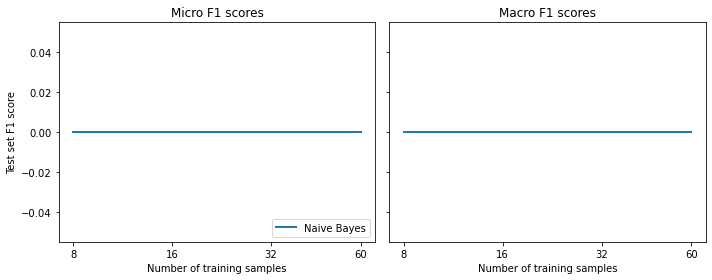

In [109]:
plot_metrics(micro_scores, macro_scores, train_samples, "Naive Bayes")


# Zero Shot Classification

In [110]:
from transformers import pipeline

In [111]:
# device = -1 uses CPU, device = 0 uses GPU
pipe = pipeline("zero-shot-classification", device=-1)

No model was supplied, defaulted to facebook/bart-large-mnli (https://huggingface.co/facebook/bart-large-mnli)


In [112]:
sample = ds["train"][0]
print(f"Labels: {sample['labels']}")
output = pipe(sample["text"], all_labels, multi_label=True)
print(output["sequence"][:400])
print("\nPredictions:")

for label, score in zip(output["labels"], output["scores"]):
    print(f"{label}, {score:.2f}")

Labels: report, shan
RT @OCHAAsiaPac: 🇲🇲 Deteriorating humanitarian situation in Shan State #Myanmar 

🇮🇩 Flooding in Serang and Cilegon in #Indonesia hits over…

Predictions:
report, 0.92
event, 0.81
rohingya, 0.13
women, 0.07
policy, 0.02
prison, 0.00
elections, 0.00


In [113]:
def zero_shot_pipeline(example):
    output = pipe(example["text"], all_labels, multi_label=True)
    example["predicted_labels"] = output["labels"]
    example["scores"] = output["scores"]
    return example

ds_zero_shot = ds["valid"].map(zero_shot_pipeline)

  0%|          | 0/30 [00:00<?, ?ex/s]

## Pick the top K labels

In [114]:
def get_preds(example, threshold=None, topk=None):
    preds = []
    if threshold:
        for label, score in zip(example["predicted_labels"], example["scores"]):
            if score >= threshold:
                preds.append(label)
    elif topk:
        for i in range(topk):
            preds.append(example["predicted_labels"][i])
    else:
        raise ValueError("Set either `threshold` or `topk`.")
    return {"pred_label_ids": list(np.squeeze(mlb.transform([preds])))}


In [115]:
def get_clf_report(ds):
    y_true = np.array(ds["label_ids"])
    y_pred = np.array(ds["pred_label_ids"])
    return classification_report(
        y_true, y_pred, target_names=mlb.classes_, zero_division=0,
        output_dict=True)


  0%|          | 0/30 [00:00<?, ?ex/s]

  0%|          | 0/30 [00:00<?, ?ex/s]

  0%|          | 0/30 [00:00<?, ?ex/s]

  0%|          | 0/30 [00:00<?, ?ex/s]

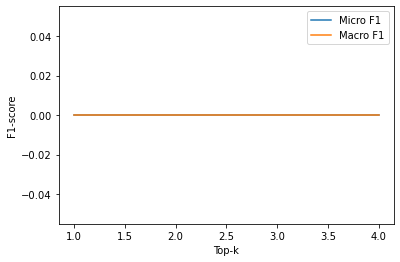

In [116]:
macros, micros = [], []
topks = [1, 2, 3, 4]
for topk in topks:
    ds_zero_shot = ds_zero_shot.map(get_preds, batched=False,
                                    fn_kwargs={'topk': topk})
    clf_report = get_clf_report(ds_zero_shot)
    micros.append(clf_report['micro avg']['f1-score'])
    macros.append(clf_report['macro avg']['f1-score'])

plt.plot(topks, micros, label='Micro F1')
plt.plot(topks, macros, label='Macro F1')
plt.xlabel("Top-k")
plt.ylabel("F1-score")
plt.legend(loc='best')
plt.show()
